<a href="https://colab.research.google.com/github/Jayasri02Sridharan/Reinsurance-Pricing-Claim-Simulation/blob/main/5_Inflation_adjusted_loss_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

### 1. Inflation Adjustment

In [ ]:
df = pd.read_csv("/content/allstate_cleaned_claims.csv")

# create synthetic accident year
np.random.seed(42)

df["accident_year"] = np.random.choice(
    np.arange(2015, 2025),
    size=len(df),
    replace=True
)

df.head()

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont10,cont11,cont12,cont13,cont14,loss,accident_year,cpi_index,inflation_factor,loss_infl_adj
0,1,A,B,A,B,A,A,A,A,B,...,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18,2021,105,1.238095,2740.127619
1,2,A,B,A,A,A,A,A,A,B,...,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60,2018,130,1.000000,1283.600000
2,5,A,B,A,A,B,A,A,A,B,...,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09,2022,120,1.083333,3255.514167
3,10,B,B,A,B,A,A,A,A,B,...,0.44467,0.327915,0.321570,0.605077,0.602642,939.85,2019,112,1.160714,1090.897321
4,11,A,B,A,B,A,A,A,A,B,...,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85,2021,100,1.300000,3593.005000


In [ ]:
# Define inflation adjustment function
def inflate_loss(loss, year, base_year=2025, inflation_rate=0.06):
    return loss * ((1 + inflation_rate) ** (base_year - year))

inflation_rate = 0.06

df["loss_infl_adj"] = df.apply(
    lambda row: inflate_loss(row["loss"], row["accident_year"], base_year=2025, inflation_rate=inflation_rate),
    axis=1
)

df[["loss", "accident_year", "loss_infl_adj"]].head()

,loss,accident_year,loss_infl_adj
0,2213.18,2021,2794.088758
1,1283.60,2018,1930.059800
2,3005.09,2022,3579.110271
3,939.85,2019,1333.195188
4,2763.85,2021,3489.296946


### 2. Compare original vs inflated losses

In [ ]:
print("Original Mean Loss:", df["loss"].mean())
print("Inflation Adjusted Mean Loss:", df["loss_infl_adj"].mean())

print("Original 99% Quantile:", df["loss"].quantile(0.99))
print("Inflation Adjusted 99% Quantile:", df["loss_infl_adj"].quantile(0.99))

Original Mean Loss: 3037.3376856699833
Inflation Adjusted Mean Loss: 4242.361614700529
Original 99% Quantile: 13981.202999999998
Inflation Adjusted 99% Quantile: 20050.749107339245


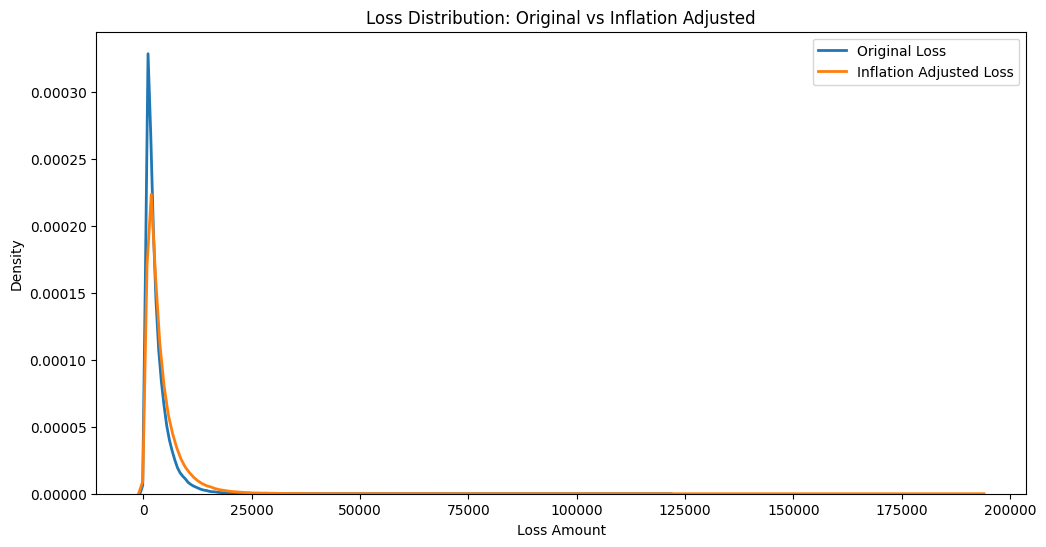

In [ ]:
# plot comparison distributions
plt.figure(figsize=(12,6))

sns.kdeplot(df["loss"], label="Original Loss", linewidth=2)
sns.kdeplot(df["loss_infl_adj"], label="Inflation Adjusted Loss", linewidth=2)

plt.title("Loss Distribution: Original vs Inflation Adjusted")
plt.xlabel("Loss Amount")
plt.ylabel("Density")
plt.legend()
plt.show()

### 3. Severity fit on inflation adjusted loss

In [ ]:
loss_adj = df["loss_infl_adj"].values
loss_adj = loss_adj[np.isfinite(loss_adj)]
loss_adj = loss_adj[loss_adj > 0]

sigma_hat, loc_hat, scale_hat = stats.lognorm.fit(loss_adj, floc=0)

print("Lognormal sigma (inflation adjusted):", sigma_hat)
print("Lognormal scale (inflation adjusted):", scale_hat)

Lognormal sigma (inflation adjusted): 0.828493849033418
Lognormal scale (inflation adjusted): 2997.8545318022807


### 4. Recalculate Reinsurance Pricing under Inflation

In [ ]:
# Frequency assumption
mu_N = 15000
r_hat = 5000
p_hat = r_hat / (r_hat + mu_N)

n_years = 20000
np.random.seed(42)

N_sim = stats.nbinom.rvs(n=r_hat, p=p_hat, size=n_years)


In [ ]:
# Simulate annual aggregate loss under inflation-adjusted severity
S_sim_infl = np.zeros(n_years)

for i in range(n_years):
    n_claims = N_sim[i]
    if n_claims > 0:
        severities = stats.lognorm.rvs(s=sigma_hat, scale=scale_hat, size=n_claims)
        S_sim_infl[i] = severities.sum()

print("Mean Aggregate Loss (infl adj):", np.mean(S_sim_infl))
print("VaR 99% Aggregate Loss (infl adj):", np.quantile(S_sim_infl, 0.99))

Mean Aggregate Loss (infl adj): 63383881.82748958
VaR 99% Aggregate Loss (infl adj): 66132027.43287595


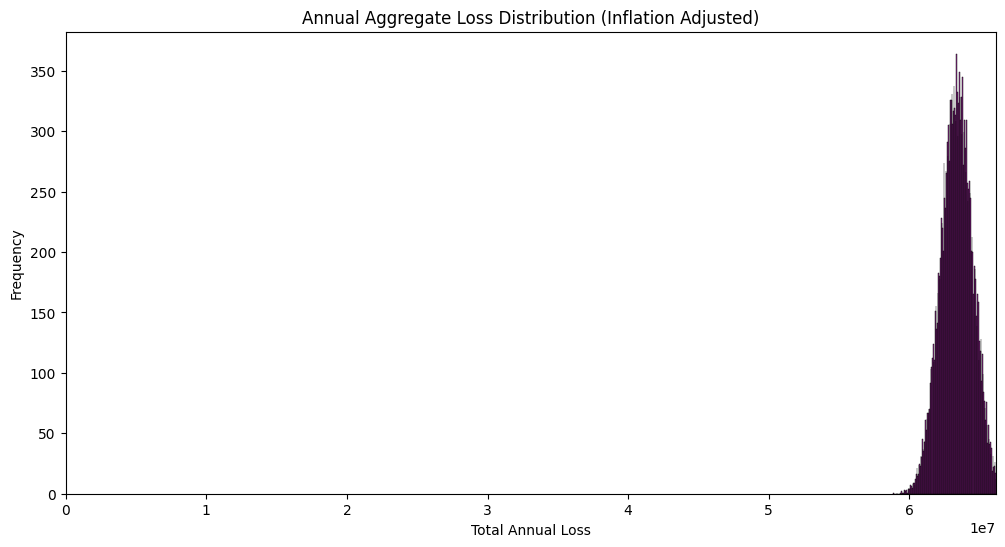

In [ ]:
# Plot aggregate loss distribution (inflation-adjusted)
plt.figure(figsize=(12,6))
sns.histplot(S_sim_infl, bins=200, color="purple", alpha=0.8)
plt.title("Annual Aggregate Loss Distribution (Inflation Adjusted)")
plt.xlabel("Total Annual Loss")
plt.ylabel("Frequency")
plt.xlim(0, np.quantile(S_sim_infl, 0.99))
plt.show()

### 5. Pricing XL contract under inflation

In [ ]:
# choose retention from quantiles
R = np.quantile(loss_adj, 0.95)
L = np.quantile(loss_adj, 0.995) - R

print("Retention (95% quantile):", R)
print("Limit:", L)

Retention (95% quantile): 12022.145874908
Limit: 12198.38323945704


In [ ]:
# Simulate XL ceded losses
ceded_XL_infl = np.zeros(n_years)

for i in range(n_years):
    n_claims = N_sim[i]
    if n_claims > 0:
        severities = stats.lognorm.rvs(s=sigma_hat, scale=scale_hat, size=n_claims)
        ceded = np.minimum(np.maximum(severities - R, 0), L)
        ceded_XL_infl[i] = ceded.sum()

In [ ]:
# Premium calculation
loading = 0.25

EL_XL_infl = np.mean(ceded_XL_infl)
premium_XL_infl = EL_XL_infl * (1 + loading)

print("Expected XL Ceded Loss (infl adj):", EL_XL_infl)
print("Premium XL (infl adj):", premium_XL_infl)

Expected XL Ceded Loss (infl adj): 3374102.8666225127
Premium XL (infl adj): 4217628.583278141


#

### 6. Stop Loss Pricing under inflation

In [ ]:
A = np.quantile(S_sim_infl, 0.90)

ceded_SL_infl = np.maximum(S_sim_infl - A, 0)

EL_SL_infl = np.mean(ceded_SL_infl)
premium_SL_infl = EL_SL_infl * (1 + loading)

print("Stop Loss Attachment:", A)
print("Expected SL Ceded Loss:", EL_SL_infl)
print("Premium SL:", premium_SL_infl)

Stop Loss Attachment: 64869007.17940619
Expected SL Ceded Loss: 55894.38610437828
Premium SL: 69867.98263047285


### 7. Sensitivity Analysis

In [ ]:
inflation_rates = [0.03, 0.05, 0.07, 0.10]
results = []

for inf in inflation_rates:
    df["loss_adj_temp"] = df.apply(
        lambda row: inflate_loss(row["loss"], row["accident_year"], base_year=2025, inflation_rate=inf),
        axis=1
    )

    loss_temp = df["loss_adj_temp"].values
    loss_temp = loss_temp[np.isfinite(loss_temp)]
    loss_temp = loss_temp[loss_temp > 0]

    sigma_t, loc_t, scale_t = stats.lognorm.fit(loss_temp, floc=0)

    # simulate one year aggregate mean approx (fast method)
    sample_losses = stats.lognorm.rvs(s=sigma_t, scale=scale_t, size=50000)

    results.append({
        "Inflation_Rate": inf,
        "Mean_Adj_Loss": np.mean(loss_temp),
        "VaR99_Adj_Loss": np.quantile(loss_temp, 0.99),
        "Fitted_Sigma": sigma_t,
        "Fitted_Scale": scale_t
    })

sens_table = pd.DataFrame(results)
sens_table

,Inflation_Rate,Mean_Adj_Loss,VaR99_Adj_Loss,Fitted_Sigma,Fitted_Scale
0,0.03,3585.839992,16565.167278,0.816058,2560.078561
1,0.05,4010.301961,18819.386111,0.823495,2845.614927
2,0.07,4488.710537,21439.852811,0.834294,3156.693728
3,0.10,5322.316589,26337.569717,0.856105,3675.038770


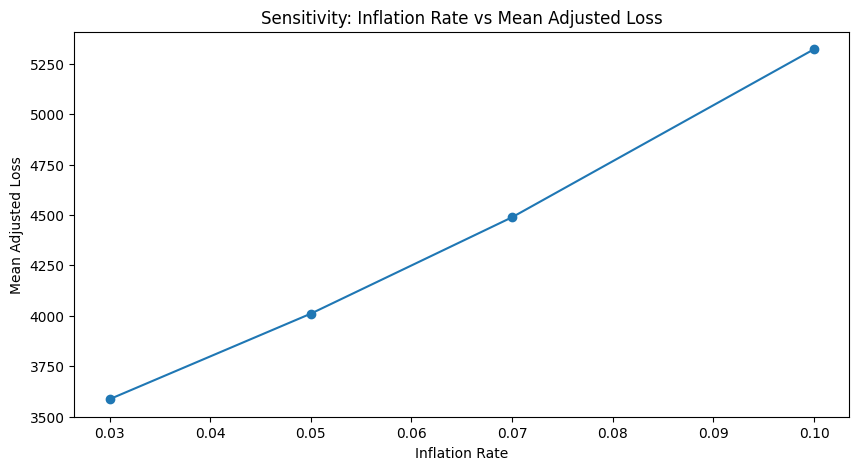

In [ ]:
# plot sensitivity trend
plt.figure(figsize=(10,5))
plt.plot(sens_table["Inflation_Rate"], sens_table["Mean_Adj_Loss"], marker="o")
plt.title("Sensitivity: Inflation Rate vs Mean Adjusted Loss")
plt.xlabel("Inflation Rate")
plt.ylabel("Mean Adjusted Loss")
plt.show()

### 8. Export results for shiny dashboard

In [ ]:
summary_table = pd.DataFrame({
    "Metric": ["Mean Severity", "VaR99 Severity", "Mean Aggregate", "VaR99 Aggregate",
               "Expected XL Ceded", "Premium XL", "Expected SL Ceded", "Premium SL"],
    "Inflation_Adjusted": [
        np.mean(loss_adj),
        np.quantile(loss_adj, 0.99),
        np.mean(S_sim_infl),
        np.quantile(S_sim_infl, 0.99),
        EL_XL_infl,
        premium_XL_infl,
        EL_SL_infl,
        premium_SL_infl
    ]
})

import os

os.makedirs("../data/processed", exist_ok=True)
summary_table.to_csv("../data/processed/dashboard_summary.csv", index=False)
sens_table.to_csv("../data/processed/dashboard_sensitivity.csv", index=False)

print("✅ Exported dashboard files into data/processed/")

✅ Exported dashboard files into data/processed/
